In [2]:
import ehtplot
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u
from common  import dalt  as d
from common  import viz

In [3]:
with fits.open('data/img-results/ring1.fits') as hdul:
    img = d.Image(hdul[0].data.T, 4.14e6 * u.Msun, 2.5077305106e+22 * u.cm, 86e9 * u.H, 0, 79.52842452054078 * 160 / 400, 79.52842452054078 * 160 / 400)

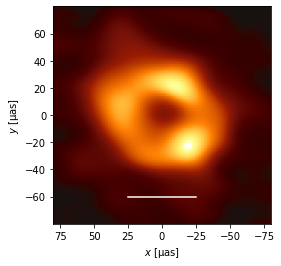

In [4]:
fig, ax = plt.subplots(1,1)

viz.show(img, ax=ax, cmap='afmhot_10us')
ax.plot([-25,25], [-60,-60], 'w')

In [5]:
from copy import copy
from math import ceil
from astropy import units
from common import mockservation as ms

def truncation_scale(tolerant=0.01, n=2):
    return (1/(tolerant*tolerant) - 1)**(0.5/n)

def compress(imgs, N=None, eht_f=15e9):
    meta = copy(imgs.meta)
    fov  = imgs.fov.to(units.rad).value
    
    spec, U, V = ms.upfft(imgs, *fov, N=N)
    
    u = np.linspace(-U/2,U/2,spec.shape[-2],endpoint=False)
    v = np.linspace( 0,  V/2,spec.shape[-1])
    u, v = np.meshgrid(u, v, indexing='ij')
    
    n  = 2
    rr = (u*u + v*v) / (eht_f*eht_f)
    Bw = 1 / np.sqrt(1 + rr**n)
    
    Nu =    spec.shape[-2]
    Nv = 2*(spec.shape[-1]-1)
    
    scale = truncation_scale(n=n)
    Ndown = [
        2 * ceil(abs(Nu * scale * eht_f / U / 2)),
        2 * ceil(abs(Nv * scale * eht_f / V / 2)),
    ]
    
    print(Ndown)
    
    print(Bw.shape, spec.shape)
    
    print(Ndown)
    
    I, W, H = ms.downifft(spec * Bw[np.newaxis,:,:], U, V, N=Ndown)
    
    meta.width  = abs(W * meta.dist).to(meta.rg)
    meta.height = abs(H * meta.dist).to(meta.rg)
    return dalt.Image(I, meta=meta)

In [6]:
import h5py
from common import dalt
from common import io_ipole as io

def readimg(f):
    with h5py.File(f) as h:
        m    = h['meta']
        meta = dalt.ImageMeta(**{k:m[k][()] for k in m.keys()})
        data = h['data'][:]
        
    return dalt.Image(data, meta=meta)

In [7]:
from common import hallmark as hm

In [8]:
pf = hm.ParaFrame('model/Illinois_thermal/230GHz/Ma+0.5_w5/img_s{snapshot}_Rh40_i30.h5')

In [9]:
mov = io.load_mov(pf.path)

In [48]:
mov_eht = compress(mov, eht_f=5e9)

(400, 400) -> [400 400]
[50, 50]
(400, 201) (830, 400, 201)
[50, 50]


In [38]:
from common import viz

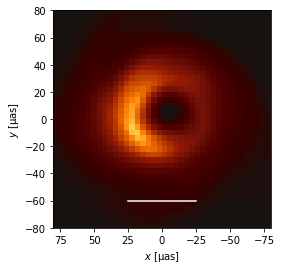

In [56]:
fig, ax = plt.subplots(1,1)
ax = viz.show(mov_eht, s=800, ax=ax, cmap='afmhot_10us', vmin=0, vmax=3e-4)
ax.set_xlim( 80,-80)
ax.set_ylim(-80, 80)
ax.plot([-25,25], [-60,-60], 'w')

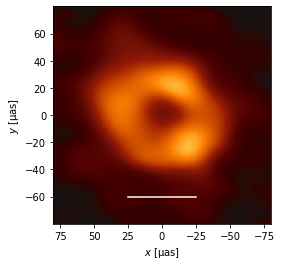

In [51]:
fig, ax = plt.subplots(1,1)
viz.show(img, ax=ax, cmap='afmhot_10us', vmin=0, vmax=1e-3)
ax.plot([-25,25], [-60,-60], 'w')